In [1]:

import numpy as np # linear algebra
import os
from tqdm import tqdm
from tensorflow import keras
import cv2
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
import matplotlib.pyplot as plt

In [2]:
labels = ['NORMAL', 'PNEUMONIA']
image_size = 150
data_dirs = ["train", "val", "test"]

In [3]:
# Initialize lists for data
image_data = []
label_data = []

In [4]:
print("Pre-processing data\n")

# Load and process images from each directory
base_path = "chest_xray"  # Adjusted to match your directory structure
for data_dir in data_dirs:
    for label in labels:
        data_path = os.path.join(base_path, data_dir, label)
        
        # Check if directory exists
        if not os.path.exists(data_path):
            print(f"Warning: Directory not found: {data_path}")
            continue
            
        # Process each image in the directory
        for image_file in tqdm(os.listdir(data_path), desc=f"Processing {data_dir}/{label}"):
            try:
                # Construct full image path
                image_path = os.path.join(data_path, image_file)
                
                # Read and resize image
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Could not load image: {image_path}")
                    continue
                    
                image = cv2.resize(image, (image_size, image_size))
                
                # Append data
                image_data.append(image)
                label_data.append(label)
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")

# Convert to numpy arrays
image_data = np.array(image_data)
label_data = np.array(label_data)

# Shuffle the data
image_data, label_data = shuffle(image_data, label_data, random_state=42)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    image_data, 
    label_data, 
    test_size=0.2, 
    random_state=42
)

Pre-processing data



Processing test/PNEUMONIA: 100%|████████████████████████████████████████████████████| 390/390 [00:02<00:00, 145.29it/s]


In [5]:
# Function to plot metrics
def plot_metric(history_inception, metric, title):
    plt.plot(history_inception.history[metric], label=f'Train {metric}')
    plt.plot(history_inception.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
# Convert labels to categorical format
def convert_labels(label_list, label_mapping):
    return to_categorical([label_mapping.index(label) for label in label_list])

# Convert train and test labels
Y_train = convert_labels(Y_train, labels)
Y_test = convert_labels(Y_test, labels)

print(f"\nData preprocessing complete:")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Image shape: {X_train[0].shape}")


Data preprocessing complete:
Training samples: 4684
Testing samples: 1172
Image shape: (150, 150, 3)


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow import keras

# Redefine the model to ensure correctness
vgg = VGG16(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
modelvgg = Model(inputs=vgg.input, outputs=prediction)


In [7]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
# Load VGG19 base model
vgg19 = VGG19(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in vgg19.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(vgg19.output)
prediction = Dense(2, activation='softmax')(x)

# Create the complete model
model_vgg19 = Model(inputs=vgg19.input, outputs=prediction)
model_vgg19.summary()

80134624/80134624 [==============================] - 15s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                           

In [10]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # Reduced patience since 10 epochs isn't long
    restore_best_weights=True
)
# Compile the model
model_vgg19.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.AUC(name='auc'),
        keras.metrics.Accuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='roc_auc', curve='ROC')
    ]
)



In [13]:
history_vgg19 = model_vgg19.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=10,
    validation_data=(X_test, Y_test), 
    callbacks=[callback]
)

Epoch 1/10
469/469 [==============================] - 289s 616ms/step - loss: 1.0981 - auc: 0.9711 - accuracy: 0.8194 - precision: 0.9667 - recall: 0.9667 - roc_auc: 0.9711 - val_loss: 5.1195 - val_auc: 0.9233 - val_accuracy: 0.8426 - val_precision: 0.9147 - val_recall: 0.9147 - val_roc_auc: 0.9233
Epoch 2/10
469/469 [==============================] - 288s 615ms/step - loss: 1.1704 - auc: 0.9715 - accuracy: 0.8787 - precision: 0.9673 - recall: 0.9673 - roc_auc: 0.9715 - val_loss: 3.4826 - val_auc: 0.9431 - val_accuracy: 0.8737 - val_precision: 0.9369 - val_recall: 0.9369 - val_roc_auc: 0.9431
Epoch 3/10
469/469 [==============================] - 288s 615ms/step - loss: 0.7619 - auc: 0.9774 - accuracy: 0.8854 - precision: 0.9761 - recall: 0.9761 - roc_auc: 0.9774 - val_loss: 1.6553 - val_auc: 0.9622 - val_accuracy: 0.8699 - val_precision: 0.9608 - val_recall: 0.9608 - val_roc_auc: 0.9622
Epoch 4/10
469/469 [==============================] - 291s 621ms/step - loss: 0.2968 - auc: 0.9894 -

In [21]:
vgg19_results = {
    # 'Test Loss': test_loss,
    'Test AUC': test_auc,
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
}

In [18]:
test_loss, test_auc, test_accuracy, test_precision, test_recall, test_roc_auc = model_vgg19.evaluate(X_test, Y_test)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")  # General AUC
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")  # ROC-specific AUC


37/37 [==============================] - 46s 1s/step - loss: 1.6525 - auc: 0.9708 - accuracy: 0.9108 - precision: 0.9667 - recall: 0.9667 - roc_auc: 0.9708
Test Loss: 1.6525
Test AUC: 0.9708
Test Accuracy: 0.9108
Test Precision: 0.9667
Test Recall: 0.9667
Test ROC AUC: 0.9708


In [ ]:
Test Loss: 1.6525
Test AUC: 0.9708
Test Accuracy: 0.9108
Test Precision: 0.9667
Test Recall: 0.9667
Test ROC AUC: 0.9708

In [20]:
# Save the trained model
model_vgg19.save("modelvgg19.h5")

In [12]:

# Train the model
history = modelvgg.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=10,
    validation_data=(X_test, Y_test),
    callbacks=[callback]
)


Epoch 1/10
469/469 [==============================] - 234s 497ms/step - loss: 0.7793 - accuracy: 0.7562 - precision: 0.9652 - recall: 0.9652 - roc_auc: 0.9710 - val_loss: 1.5893 - val_accuracy: 0.8187 - val_precision: 0.9539 - val_recall: 0.9539 - val_roc_auc: 0.9554
Epoch 2/10
469/469 [==============================] - 232s 494ms/step - loss: 0.5442 - accuracy: 0.8350 - precision: 0.9742 - recall: 0.9742 - roc_auc: 0.9784 - val_loss: 1.1309 - val_accuracy: 0.8404 - val_precision: 0.9676 - val_recall: 0.9676 - val_roc_auc: 0.9699
Epoch 3/10
469/469 [==============================] - 231s 493ms/step - loss: 0.5069 - accuracy: 0.8535 - precision: 0.9763 - recall: 0.9763 - roc_auc: 0.9816 - val_loss: 1.5904 - val_accuracy: 0.8537 - val_precision: 0.9599 - val_recall: 0.9599 - val_roc_auc: 0.9670
Epoch 4/10
469/469 [==============================] - 232s 494ms/step - loss: 0.5274 - accuracy: 0.8763 - precision: 0.9769 - recall: 0.9769 - roc_auc: 0.9798 - val_loss: 1.2515 - val_accuracy: 0.

In [14]:
# Evaluate the model on the test set
test_loss, test_auc, test_accuracy, test_precision, test_recall = modelvgg.evaluate(X_test, Y_test)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")  # AUC (this includes ROC AUC)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


37/37 [==============================] - 46s 1s/step - loss: 1.1309 - accuracy: 0.8404 - precision: 0.9676 - recall: 0.9676 - roc_auc: 0.9699
Test Loss: 1.1309
Test AUC: 0.8404
Test Accuracy: 0.9676
Test Precision: 0.9676
Test Recall: 0.9699


In [ ]:
Test Loss: 1.1309
Test AUC: 0.8404
Test Accuracy: 0.9676
Test Precision: 0.9676
Test Recall: 0.9699

In [15]:
# Save the trained model
modelvgg.save("modelvgg.h5")

In [ ]:
from tensroflow.keras.models import load_model

In [ ]:

# Plot all metrics
metrics = ['auc', 'accuracy', 'precision', 'recall', 'roc_auc', 'loss']
titles = [
    'AUC vs Epochs', 'Accuracy vs Epochs', 'Precision vs Epochs',
    'Recall vs Epochs', 'ROC AUC vs Epochs', 'Loss vs Epochs'
]

for metric, title in zip(metrics, titles):
    plot_metric(history, metric, title)

In [16]:
# Store VGG16 results
vgg16_results = {
    'Test Loss': test_loss,
    'Test AUC': test_auc,
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
}

In [6]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras

# Load InceptionV3 base model
inception = InceptionV3(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in inception.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(inception.output)
prediction = Dense(2, activation='softmax')(x)

# Create the complete model
model_inception = Model(inputs=inception.input, outputs=prediction)
model_inception.summary()


87910968/87910968 [==============================] - 13s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                            

In [9]:

# Compile the model
model_inception.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.AUC(name='auc'),
        keras.metrics.Accuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='roc_auc', curve='ROC')
    ]
)

# Early stopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)


In [10]:

# Train the model
history_inception = model_inception.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=10,
    validation_data=(X_test, Y_test),
    callbacks=[callback]
)

Epoch 1/10
469/469 [==============================] - 98s 197ms/step - loss: 24.2852 - auc: 0.9058 - accuracy: 0.8834 - precision: 0.9044 - recall: 0.9044 - roc_auc: 0.9058 - val_loss: 11.7858 - val_auc: 0.9350 - val_accuracy: 0.9121 - val_precision: 0.9343 - val_recall: 0.9343 - val_roc_auc: 0.9350
Epoch 2/10
469/469 [==============================] - 79s 169ms/step - loss: 21.9314 - auc: 0.9090 - accuracy: 0.8908 - precision: 0.9082 - recall: 0.9082 - roc_auc: 0.9090 - val_loss: 32.4636 - val_auc: 0.8705 - val_accuracy: 0.8383 - val_precision: 0.8686 - val_recall: 0.8686 - val_roc_auc: 0.8705
Epoch 3/10
469/469 [==============================] - 74s 159ms/step - loss: 25.0143 - auc: 0.9173 - accuracy: 0.9029 - precision: 0.9161 - recall: 0.9161 - roc_auc: 0.9173 - val_loss: 17.2571 - val_auc: 0.9288 - val_accuracy: 0.9078 - val_precision: 0.9249 - val_recall: 0.9249 - val_roc_auc: 0.9288
Epoch 4/10
469/469 [==============================] - 74s 157ms/step - loss: 16.2424 - auc: 0.928

In [17]:

test_loss, test_auc, test_accuracy, test_precision, test_recall, test_roc_auc = model_inception.evaluate(X_test, Y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")  
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


37/37 [==============================] - 12s 313ms/step - loss: 11.7858 - auc: 0.9350 - accuracy: 0.9121 - precision: 0.9343 - recall: 0.9343 - roc_auc: 0.9350
Test Loss: 11.7858
Test AUC: 0.9350
Test Accuracy: 0.9121
Test Precision: 0.9343
Test Recall: 0.9343


In [ ]:
Test Loss: 11.7858
Test AUC: 0.9350
Test Accuracy: 0.9121
Test Precision: 0.9343
Test Recall: 0.9343

In [ ]:
# Store VGG16 results
inceptionV3_results = {
    'Test Loss': test_loss,
    'Test AUC': test_auc,
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
}

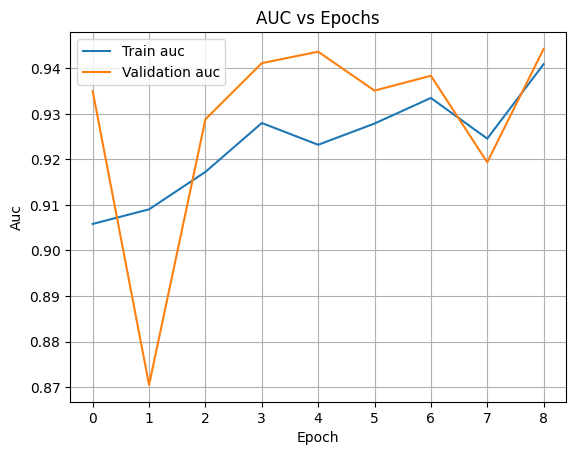

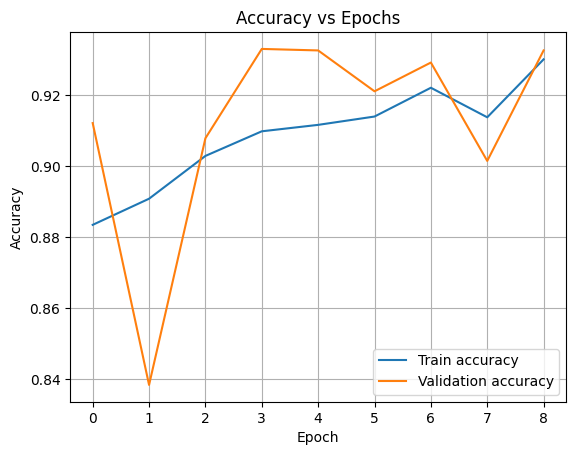

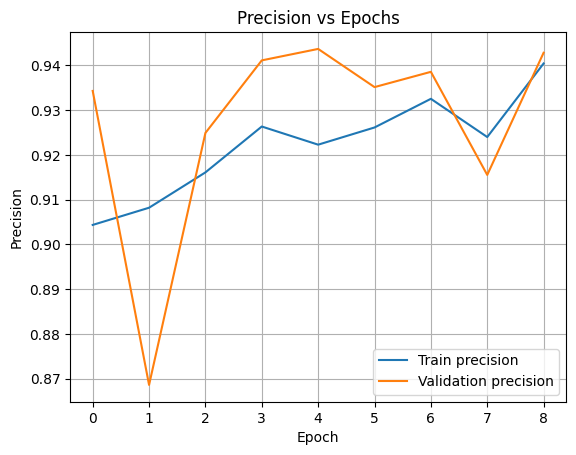

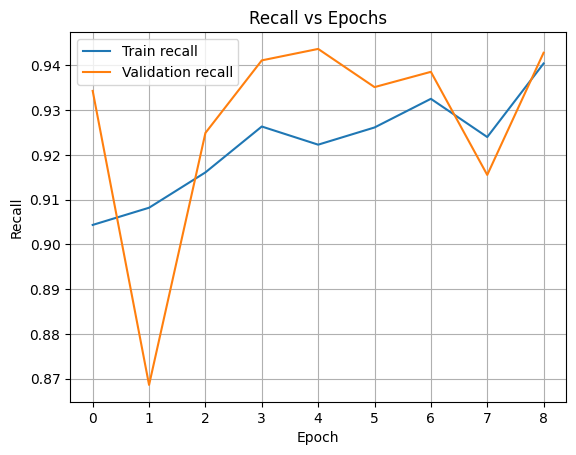

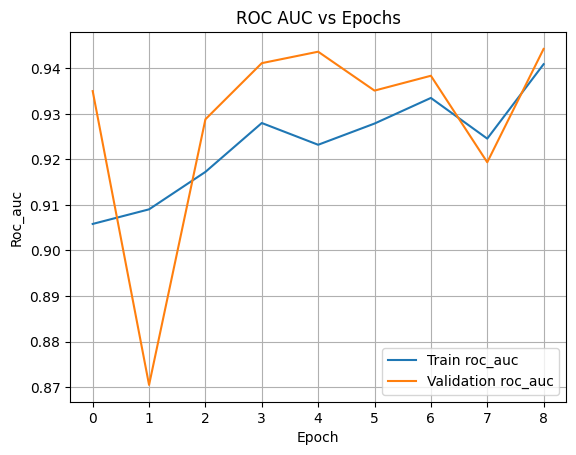

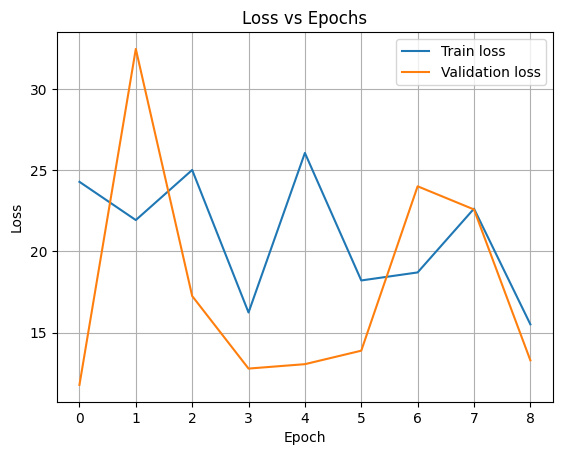

In [20]:
# Plot all metrics
metrics = ['auc', 'accuracy', 'precision', 'recall', 'roc_auc', 'loss']
titles = [
    'AUC vs Epochs', 'Accuracy vs Epochs', 'Precision vs Epochs',
    'Recall vs Epochs', 'ROC AUC vs Epochs', 'Loss vs Epochs'
]

for metric, title in zip(metrics, titles):
    plot_metric(history_inception, metric, title)

In [21]:
# Save the trained model
model_inception.save("modelInception.h5")

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras

# Load ResNet50 base model
# resnet = ResNet50(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in resnet.layers:
    layer.trainable = False

for layer in resnet.layers[-10:]:  # Unfreeze last 10 layers
    layer.trainable = True

# Add custom layers
x = Flatten()(resnet.output)
prediction = Dense(2, activation='softmax')(x)

# Create the complete model
model_resnet = Model(inputs=resnet.input, outputs=prediction)



In [8]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [13]:

# Compile the model
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.AUC(name='auc'),
        keras.metrics.Accuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='roc_auc', curve='ROC')
    ]
)

# Early stopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)


In [ ]:

# Train the model
history_resnet = model_resnet.fit(
    X_train, Y_train,
    epochs=15,
    batch_size=10,
    validation_data=(X_test, Y_test),
    callbacks=[callback]
)

In [11]:

test_loss, test_auc, test_accuracy, test_precision, test_recall, test_roc_auc = model_resnet.evaluate(X_test, Y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")  
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

37/37 [==============================] - 24s 640ms/step - loss: 1.0357 - auc: 0.9620 - accuracy: 0.6357 - precision: 0.9505 - recall: 0.9505 - roc_auc: 0.9620
Test Loss: 1.0357
Test AUC: 0.9620
Test Accuracy: 0.6357
Test Precision: 0.9505
Test Recall: 0.9505


In [ ]:
Test Loss: 1.0357
Test AUC: 0.9620
Test Accuracy: 0.6357
Test Precision: 0.9505
Test Recall: 0.9505

In [16]:
model_resnet.save("modelResnet.h5")

In [15]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras

# Load EfficientNetB0 base model
efficientnet = EfficientNetB0(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in efficientnet.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(efficientnet.output)
prediction = Dense(2, activation='softmax')(x)

# Create the complete model
model_efficientnet = Model(inputs=efficientnet.input, outputs=prediction)
model_efficientnet.summary()


16705208/16705208 [==============================] - 14s 1us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)  

In [17]:

# Compile the model
model_efficientnet.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[
        keras.metrics.AUC(name='auc'),
        keras.metrics.Accuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='roc_auc', curve='ROC')
    ]
)

# Early stopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Train the model
history_efficientnet = model_efficientnet.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=10,
    validation_data=(X_test, Y_test),
    callbacks=[callback]
)

Epoch 1/10
469/469 [==============================] - 103s 203ms/step - loss: 0.5727 - auc: 0.9541 - accuracy: 0.2876 - precision: 0.9180 - recall: 0.9180 - roc_auc: 0.9541 - val_loss: 0.6327 - val_auc: 0.9472 - val_accuracy: 0.3183 - val_precision: 0.9044 - val_recall: 0.9044 - val_roc_auc: 0.9472
Epoch 2/10
469/469 [==============================] - 95s 203ms/step - loss: 0.3072 - auc: 0.9741 - accuracy: 0.3762 - precision: 0.9556 - recall: 0.9556 - roc_auc: 0.9741 - val_loss: 0.3105 - val_auc: 0.9766 - val_accuracy: 0.3699 - val_precision: 0.9573 - val_recall: 0.9573 - val_roc_auc: 0.9766
Epoch 3/10
469/469 [==============================] - 96s 205ms/step - loss: 0.3536 - auc: 0.9760 - accuracy: 0.3921 - precision: 0.9584 - recall: 0.9584 - roc_auc: 0.9760 - val_loss: 0.6854 - val_auc: 0.9639 - val_accuracy: 0.4036 - val_precision: 0.9445 - val_recall: 0.9445 - val_roc_auc: 0.9639
Epoch 4/10
469/469 [==============================] - 95s 202ms/step - loss: 0.3124 - auc: 0.9786 - ac

In [ ]:

test_loss, test_auc, test_accuracy, test_precision, test_recall, test_roc_auc = model_efficientnet.evaluate(X_test, Y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")  
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


In [ ]:
Test Loss: 0.5165
Test AUC: 0.9753
Test Accuracy: 0.5273
Test Precision: 0.9676
Test Recall: 0.9676

In [ ]:
model_efficientnet.save("model/modelEfficient.h5")

In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras

# Load MobileNetV2 base model
mobilenet = MobileNetV2(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in mobilenet.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(mobilenet.output)
prediction = Dense(2, activation='softmax')(x)

# Create the complete model
model_mobilenet = Model(inputs=mobilenet.input, outputs=prediction)
model_mobilenet.summary()


9406464/9406464 [==============================] - 21s 2us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)          

In [27]:

# Compile the model
model_mobilenet.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.AUC(name='auc'),
        keras.metrics.Accuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='roc_auc', curve='ROC')
    ]
)

# Early stopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Train the model
history_mobilenet = model_mobilenet.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=10,
    validation_data=(X_test, Y_test),
    callbacks=[callback]
)

Epoch 1/10
469/469 [==============================] - 74s 151ms/step - loss: 0.8593 - auc: 0.9260 - accuracy: 0.2521 - precision: 0.8854 - recall: 0.8854 - roc_auc: 0.9260 - val_loss: 1.7256 - val_auc: 0.8385 - val_accuracy: 0.1766 - val_precision: 0.7867 - val_recall: 0.7867 - val_roc_auc: 0.8385
Epoch 2/10
469/469 [==============================] - 70s 149ms/step - loss: 0.6739 - auc: 0.9531 - accuracy: 0.3619 - precision: 0.9270 - recall: 0.9270 - roc_auc: 0.9531 - val_loss: 0.6176 - val_auc: 0.9584 - val_accuracy: 0.3831 - val_precision: 0.9377 - val_recall: 0.9377 - val_roc_auc: 0.9584
Epoch 3/10
469/469 [==============================] - 72s 154ms/step - loss: 0.5382 - auc: 0.9653 - accuracy: 0.3931 - precision: 0.9473 - recall: 0.9473 - roc_auc: 0.9653 - val_loss: 0.8545 - val_auc: 0.9447 - val_accuracy: 0.4053 - val_precision: 0.9258 - val_recall: 0.9258 - val_roc_auc: 0.9447
Epoch 4/10
469/469 [==============================] - 72s 153ms/step - loss: 0.4141 - auc: 0.9719 - acc

In [28]:

test_loss, test_auc, test_accuracy, test_precision, test_recall, test_roc_auc = model_mobilenet.evaluate(X_test, Y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")  
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


37/37 [==============================] - 9s 241ms/step - loss: 0.6176 - auc: 0.9584 - accuracy: 0.3831 - precision: 0.9377 - recall: 0.9377 - roc_auc: 0.9584
Test Loss: 0.6176
Test AUC: 0.9584
Test Accuracy: 0.3831
Test Precision: 0.9377
Test Recall: 0.9377


In [ ]:
Test Loss: 0.6176
Test AUC: 0.9584
Test Accuracy: 0.3831
Test Precision: 0.9377
Test Recall: 0.9377

In [30]:
model_mobilenet.save("modelMobilenet.h5")
